In [4]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain
from sklearn import preprocessing
from scipy.spatial import distance

In [5]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0)]
divergence_time = 50
divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
divergence_event2 = msprime.MassMigration(time = 1000, source = 2, dest = 0, proportion = 1)
Ne = 100
recomb = 0.5
mutation_rate = 0.25
pops = [range(0,100),range(100,200),range(200,300)]
ts_ref = msprime.simulate(population_configurations = pop_configs,Ne = Ne,mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],
                      random_seed = 1, recombination_rate = recomb)
ref_stat = ts_ref.f3([pops[2],pops[0],pops[1]])

In [30]:
#ABC Function
def ABC_reg_adjustment(data,eps,pop_configs,pops,Ne,recomb,divergence2,prior ="exponential",prior_parameters=10,iters=1000):
    ref_stat = (data.f2([pops[0],pops[1]]),data.f3([pops[2],pops[0],pops[1]]),data.diversity())
    samples = []
    discrepancies = []
    if prior == "exponential":
        for iter in range(iters):
            mutation_rate_sim = np.random.exponential(prior_parameters[0])
            divergence_time = min(np.random.exponential(prior_parameters[1]),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate_sim,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = (ts_sim.f2([pops[0],pops[1]]),ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.diversity())
            samples.append((mutation_rate_sim,divergence_time))
            discrepancies.append(np.subtract(sim_stat,ref_stat))
    if prior == "uniform":
        for iter in range(0,iters):
            mutation_rate_sim = np.random.exponential(prior_parameters)
            divergence_time = min(np.random.uniform(prior_parameters[0],prior_parameters[1]),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = (ts_sim.f2([pops[0],pops[1]]),ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.diversity())
            samples.append(divergence_time)
            discrepancies.append(np.subtract(sim_stat,ref_stat))
    cov_matrix = np.cov(np.array(discrepancies).T)
    reduced_sample_indices = []
    discrepancies = np.array(discrepancies)
    samples = np.array(samples)
    #discrepancies = preprocessing.scale(discrepancies)+np.mean(discrepancies)
    #print(np.mean(discrepancies),np.var(discrepancies))
    for j in range(len(ref_stat)):
        #discrepancies.T[j] = preprocessing.scale(discrepancies.T[j]) + np.mean(discrepancies.T[j])
        print(np.mean(discrepancies.T[j]),np.var(discrepancies.T[j]))
    for i in range(len(samples)):
        #if np.linalg.norm(discrepancies[i]) < eps:
         #   reduced_sample_indices.append(i)
        if distance.mahalanobis(discrepancies[i],[0]*len(discrepancies[0]),np.linalg.inv(cov_matrix))< eps:
            reduced_sample_indices.append(i)   
    return(samples,discrepancies,reduced_sample_indices,cov_matrix)

In [31]:
%%time
iterations = 10000
eps = 2.5
prior= "exponential"
prior_parameters = (0.2,40)
attempt1 = ABC_reg_adjustment(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)
samples = attempt1[0]
discrepancies = attempt1[1]
reduced_sample_indices = attempt1[2]
cov_matrix=attempt1[3]
reduced_samples = np.array(samples)[np.ix_(reduced_sample_indices)]
reduced_discrepancies = np.array(discrepancies)[np.ix_(reduced_sample_indices)]
n = len(reduced_samples)
p = len(discrepancies[0])
print("Acceptance probability: ",n/iterations)

-9.287205676363632 789.7410641954302
-96.19170668303082 156610.57566493563
-64.38438832553057 69678.27230168713
Acceptance probability:  0.8994
Wall time: 4min 40s


In [36]:
cov_matrix=attempt1[3]
print(cov_matrix)

[[   789.8200462    6017.25363444   4331.04850384]
 [  6017.25363444 156626.23828876 104255.59030979]
 [  4331.04850384 104255.59030979  69685.24082577]]


In [41]:
X = np.zeros((n,p+1))
W = np.zeros((n,n))
for i in range(n):
    for j in range(p+1):
        if j == 0:
            X[i][j]=1
        else:
            X[i][j]= reduced_discrepancies[i][j-1]
    norm = distance.mahalanobis(reduced_discrepancies[i],[0]*p,np.linalg.inv(cov_matrix))
    #norm = np.linalg.norm(reduced_discrepancies[i])
    W[i][i] = 3*(1-(norm/eps)**2)/(2*eps)
    #W[i][i] = 1
XTWXinv = np.linalg.inv(np.dot(np.dot(X.T,W),X))
AB = np.dot(np.dot(np.dot(XTWXinv,X.T),W),reduced_samples)
Beta_hat = AB[1:]
alpha_hat = AB[0]
adjusted_samples = np.subtract(reduced_samples,np.dot(reduced_discrepancies,Beta_hat))
print(AB)

[[ 2.48684120e-01  5.66885128e+01]
 [-2.24981103e-04  2.66910927e+00]
 [-6.21036528e-05  1.33199011e-01]
 [ 8.68744117e-04 -3.53373794e-01]]
[[ 2.48684120e-01  5.66885128e+01]
 [-2.24981103e-04  2.66910927e+00]
 [-6.21036528e-05  1.33199011e-01]
 [ 8.68744117e-04 -3.53373794e-01]]


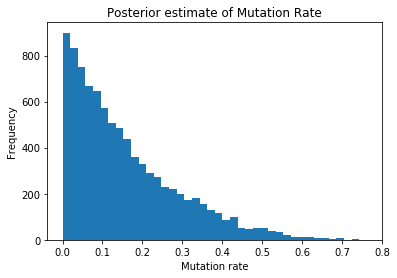

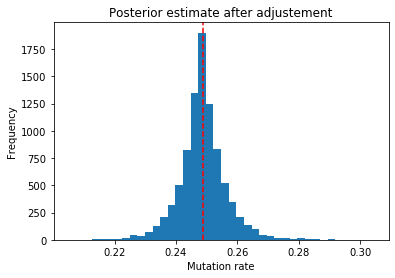

Point estimate :  0.24868412032694223


In [37]:
plt.hist(reduced_samples.T[0], bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate of Mutation Rate')
plt.show()
plt.hist(adjusted_samples.T[0], bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate after adjustement')
plt.axvline(x=alpha_hat[0],color="r",linestyle="dashed")
plt.show()
print("Point estimate : ",alpha_hat[0])

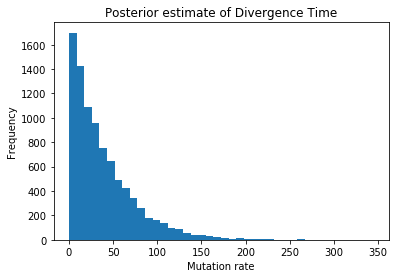

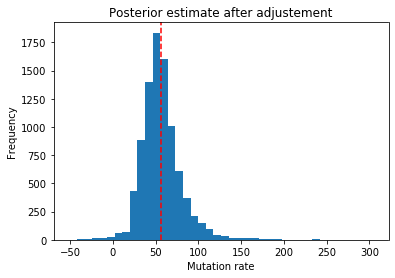

Point estimate :  56.6885127866152


In [38]:
plt.hist(reduced_samples.T[1], bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate of Divergence Time')
plt.show()
plt.hist(adjusted_samples.T[1], bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate after adjustement')
plt.axvline(x=alpha_hat[1],color="r",linestyle="dashed")
plt.show()
print("Point estimate : ",alpha_hat[1])

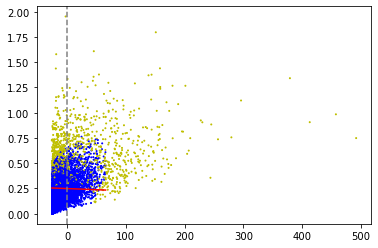

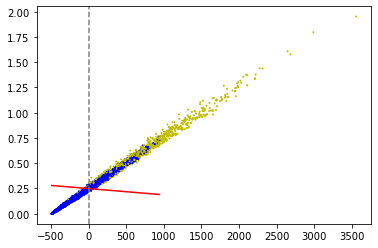

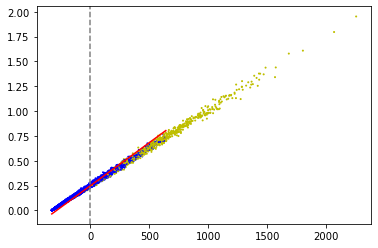

In [39]:
col = ["y"]*len(samples)
for i in reduced_sample_indices:
    col[i] = "b"
for i in range(len(discrepancies[0])):
    data = discrepancies.T[i]
    lineStart = min(reduced_discrepancies.T[i])
    lineEnd = max(reduced_discrepancies.T[i])
    plt.scatter(data,samples.T[0],s=1,color = col)
    x = np.linspace(lineStart, lineEnd, 1000)
    plt.plot(x,Beta_hat[i][0]*x + alpha_hat[0],color="r")
    plt.axvline(x=0,color="gray",linestyle="dashed")
    plt.show()

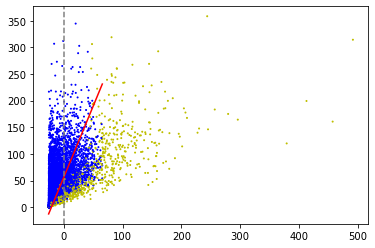

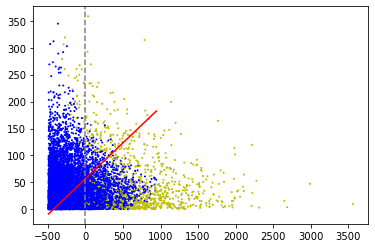

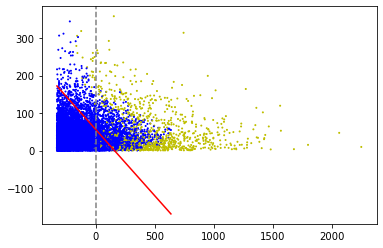

In [40]:
col = ["y"]*len(samples)
for i in reduced_sample_indices:
    col[i] = "b"
for i in range(len(discrepancies[0])):
    data = discrepancies.T[i]
    lineStart = min(reduced_discrepancies.T[i])
    lineEnd = max(reduced_discrepancies.T[i])
    plt.scatter(data,samples.T[1],s=1,color = col)
    x = np.linspace(lineStart, lineEnd, 1000)
    plt.plot(x,Beta_hat[i][1]*x + alpha_hat[1],color="r")
    plt.axvline(x=0,color="gray",linestyle="dashed")
    plt.show()